1) Bạn bổ sung thêm phần cho phép save weights sau khi train và load weights nếu đã có từ 1 đường dẫn chỉ định, và dùng weights đó để chạy inference cho ảnh hoặc tập ảnh trong thư mục, in ra kết quả dự đoán và xác suất ứng với class.
2) In ra precision + recall trong trường hợp chạy inference cho tập dữ liệu có nhãn, đồ thị biến thiên của loss và accuracy cho quá trình train.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import json
import csv
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix
import itertools
import pandas as pd

# -*- coding: utf-8 -*-
"""
Image Classification with E-ELAN Lite (PyTorch)
- EELANLite block (group conv -> channel shuffle -> concat -> 1x1 fuse + residual)
- CNN+Pooling backbone + EELANLite + GAP + Linear
- ImageFolder dataloader (train/val; if val missing, auto-split with independent transforms)
- Train/Validate with AMP (CUDA), cosine lr schedule
- Save best checkpoint; Predict image/folder top-k
"""

import os
import math
import time
import copy
from typing import List, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from torchvision.transforms import InterpolationMode
from PIL import Image
import numpy as np

# -------------------------------
# CONFIG
# -------------------------------
CFG = {
    "data_root": "/content/drive/MyDrive/22001534/ComputerVision/DATASET/CNN_MultiClass_data",  # change me
    "train_dir": "animals",
    "val_dir": "val",  # optional
    "auto_split_val_ratio": 0.1,

    "img_size": 224,
    "num_workers": 4,

    "epochs": 20,
    "batch_size": 32,
    "lr": 2e-3,
    "weight_decay": 0.05,
    "label_smoothing": 0.0,
    "amp": True,  # CUDA-only

    "C_stem": 32,
    "C_stage": 96,
    "m": 2.0,
    "g": 2,

    "use_cosine": True,
    "min_lr_scale": 0.05,

    "out_dir": "runs/cls_eelan",
    "best_ckpt": "best.pt",
    "topk": 5,

    "predict_path": None,  # set path to image or folder if you want to predict after training
    "seed": 42,

    "resume_ckpt": "/content/drive/MyDrive/22001534/ComputerVision/Lab5/runs/cls_eelan/last.pt",
    "infer_ckpt": "/content/drive/MyDrive/22001534/ComputerVision/Lab5/runs/cls_eelan/best.pt",
    "save_last": "last.pt",
    "save_optimizer_state": True,
    "preds_csv": "preds.csv",

}

Building dataloaders...
Classes (3): ['cats', 'dogs', 'panda']
Building model...
[warn] resume_ckpt not found: /content/drive/MyDrive/22001534/ComputerVision/Lab5/runs/cls_eelan/last.pt


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-156570417.py:571: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if (cfg["amp"] and device.type == "cuda") else None


Checkpoint saved: runs/cls_eelan/best.pt
Checkpoint saved: runs/cls_eelan/last.pt
Epoch 001/020 | train_loss 0.8749 acc@1 55.07% | val_loss 0.8095 acc@1 59.00% | time 40.8s
  per-class acc: cats:64.4%, dogs:30.3%, panda:85.1%
Checkpoint saved: runs/cls_eelan/best.pt
Checkpoint saved: runs/cls_eelan/last.pt
Epoch 002/020 | train_loss 0.8167 acc@1 60.11% | val_loss 0.7756 acc@1 60.33% | time 31.0s
  per-class acc: cats:52.2%, dogs:63.3%, panda:64.4%
Checkpoint saved: runs/cls_eelan/last.pt
Epoch 003/020 | train_loss 0.7840 acc@1 60.78% | val_loss 0.9870 acc@1 52.00% | time 31.3s
  per-class acc: cats:76.7%, dogs:45.9%, panda:36.6%
Checkpoint saved: runs/cls_eelan/best.pt
Checkpoint saved: runs/cls_eelan/last.pt
Epoch 004/020 | train_loss 0.6856 acc@1 65.93% | val_loss 0.7693 acc@1 62.33% | time 31.6s
  per-class acc: cats:80.0%, dogs:41.3%, panda:69.3%
Checkpoint saved: runs/cls_eelan/last.pt
Epoch 005/020 | train_loss 0.6369 acc@1 67.22% | val_loss 1.2117 acc@1 55.67% | time 30.6s
  per

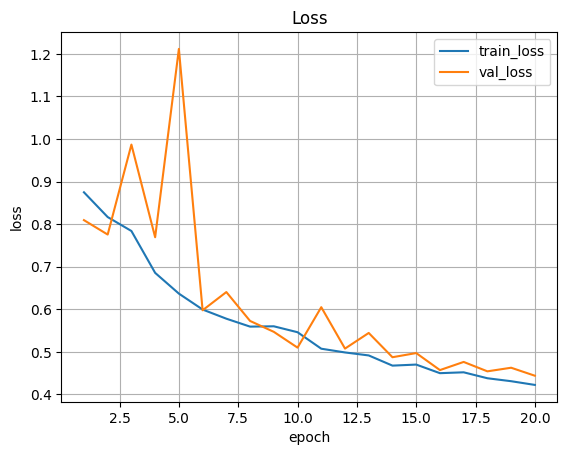

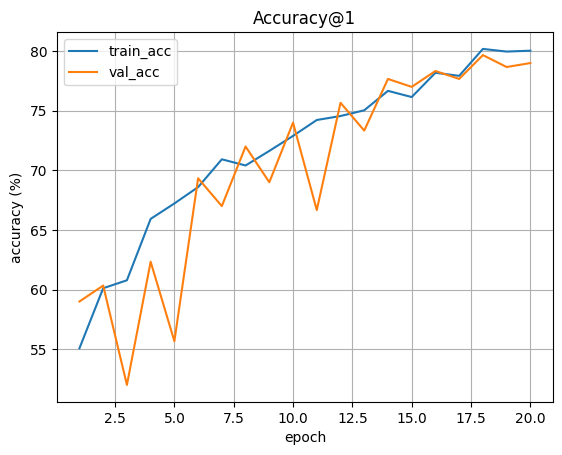

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[info] saved PR report: runs/cls_eelan/pr_report.txt


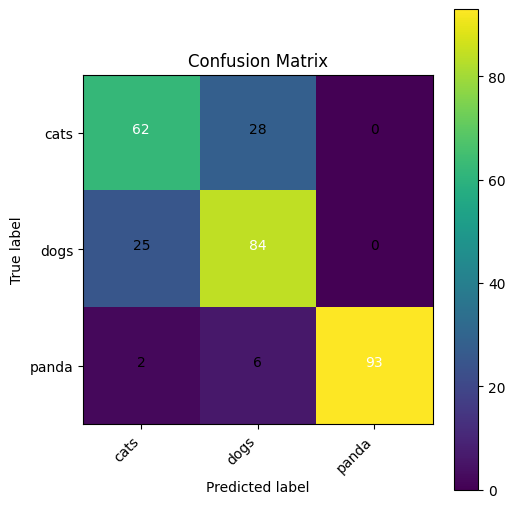

Best val acc@1: 79.67%  | checkpoint: runs/cls_eelan/best.pt


In [6]:
# -------------------------------
# Utils
# -------------------------------
def set_seed(seed=42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


class ConvBNAct(nn.Module):
    def __init__(self, c_in, c_out, k=3, s=1, p=None, g=1, act=True):
        super().__init__()
        if p is None:
            p = (k - 1) // 2
        self.conv = nn.Conv2d(c_in, c_out, k, s, p, groups=g, bias=False)
        self.bn = nn.BatchNorm2d(c_out)
        self.act = nn.SiLU(inplace=True) if act else nn.Identity()

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))


def channel_shuffle(x: torch.Tensor, groups: int) -> torch.Tensor:
    if groups <= 1:
        return x
    b, c, h, w = x.shape
    assert c % groups == 0, "channels must be divisible by groups"
    x = x.view(b, groups, c // groups, h, w)
    x = x.transpose(1, 2).contiguous()
    x = x.view(b, c, h, w)
    return x


class EELANLite(nn.Module):
    """
    Minimal E-ELAN:
      - 1x1 group conv expand to m*C (groups=g)
      - 4 branches with depths [0,1,2,3] (3x3 group conv)
      - channel shuffle per branch
      - concat -> 1x1 fuse to C_out (default C_in), residual if shapes match
    """

    def __init__(self,
                 C_in: int,
                 C_out: int = None,
                 m: float = 2.0,
                 g: int = 2,
                 branch_depths: List[int] = None,
                 use_skip: bool = True):
        super().__init__()
        assert m >= 1
        self.C_in = C_in
        self.C_out = C_in if C_out is None else C_out
        self.m = m
        self.g = g
        self.use_skip = use_skip and (self.C_out == self.C_in)

        C_exp = int(round(self.m * self.C_in))
        C_exp = max(4 * self.g, (C_exp // (4 * self.g)) * (4 * self.g))  # divisible by 4*g
        self.C_exp = C_exp

        self.expand = ConvBNAct(self.C_in, self.C_exp, k=1, s=1, p=0, g=self.g, act=True)

        self.num_branches = 4
        self.split_ch = self.C_exp // self.num_branches
        assert self.C_exp % self.num_branches == 0

        if branch_depths is None:
            branch_depths = [0, 1, 2, 3]
        self.branch_depths = branch_depths[:self.num_branches]

        branches = []
        for d in self.branch_depths:
            layers = []
            in_ch = self.split_ch
            for _ in range(d):
                layers.append(ConvBNAct(in_ch, in_ch, k=3, s=1, p=1, g=self.g, act=True))
            branches.append(nn.Sequential(*layers) if layers else nn.Identity())
        self.branches = nn.ModuleList(branches)

        self.fuse = ConvBNAct(self.C_exp, self.C_out, k=1, s=1, p=0, g=1, act=True)

    def forward(self, x):
        identity = x
        y = self.expand(x)
        chunks = torch.chunk(y, self.num_branches, dim=1)
        outs = [br(ch) for br, ch in zip(self.branches, chunks)]
        outs = [channel_shuffle(t, self.g) for t in outs]
        y = torch.cat(outs, dim=1)
        y = self.fuse(y)
        if self.use_skip and y.shape == identity.shape:
            y = y + identity
        return y


class EELANClassifier(nn.Module):
    """
    CNN+Pooling backbone with one EELANLite stage
      Stem:  Conv 3x3 s=2 -> Conv 3x3
      Stage1: MaxPool s=2 -> Conv 3x3
      EELAN stage: EELANLite(C_stage)
      Neck:  Conv 1x1
      Head:  GAP -> Linear(num_classes)
    """

    def __init__(self, num_classes: int,
                 C_in=3, C_stem=32, C_stage=96,
                 m=2.0, g=2, neck_channels=128):
        super().__init__()
        self.stem = nn.Sequential(
            ConvBNAct(C_in, C_stem, k=3, s=2),  # H/2
            ConvBNAct(C_stem, C_stem, k=3, s=1),
        )
        self.stage1 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),  # H/4
            ConvBNAct(C_stem, C_stage, k=3, s=1),
        )
        self.eelan = EELANLite(C_stage, C_stage, m=m, g=g, branch_depths=[0, 1, 2, 3], use_skip=True)
        self.neck = ConvBNAct(C_stage, neck_channels, k=1, s=1, p=0, g=1, act=True)
        self.head = nn.Linear(neck_channels, num_classes)

        # ---- FIX: init conv weights with 'relu' gain (PyTorch không hỗ trợ 'silu' ở calculate_gain) ----
        for m_ in self.modules():
            if isinstance(m_, nn.Conv2d):
                nn.init.kaiming_normal_(m_.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m_, nn.BatchNorm2d):
                nn.init.constant_(m_.weight, 1.0)
                nn.init.constant_(m_.bias, 0.0)

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.eelan(x)
        x = self.neck(x)
        x = F.adaptive_avg_pool2d(x, output_size=1).squeeze(-1).squeeze(-1)  # (B, C)
        logits = self.head(x)
        return logits


# -------------------------------
# Data
# -------------------------------
def build_transforms(img_size=224, is_train=True):
    if is_train:
        return transforms.Compose([
            transforms.Resize((img_size, img_size), interpolation=InterpolationMode.BILINEAR),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])
    else:
        return transforms.Compose([
            transforms.Resize((img_size, img_size), interpolation=InterpolationMode.BILINEAR),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])


def build_dataloaders(cfg):
    train_root = os.path.join(cfg["data_root"], cfg["train_dir"])
    val_root = os.path.join(cfg["data_root"], cfg["val_dir"])

    if os.path.isdir(val_root) and any(os.scandir(val_root)):
        # explicit train/val
        train_ds = datasets.ImageFolder(train_root, transform=build_transforms(cfg["img_size"], True))
        val_ds = datasets.ImageFolder(val_root, transform=build_transforms(cfg["img_size"], False))
    else:
        # ---- FIX: auto-split with independent datasets (avoid shared transform pitfall) ----
        base_train = datasets.ImageFolder(train_root)  # no transform
        n_total = len(base_train)
        n_val = max(1, int(round(n_total * float(cfg["auto_split_val_ratio"]))))
        n_train = n_total - n_val
        # reproducible split
        gen = torch.Generator().manual_seed(CFG["seed"])
        train_idx, val_idx = torch.utils.data.random_split(range(n_total), [n_train, n_val], generator=gen)

        train_ds_full = datasets.ImageFolder(train_root, transform=build_transforms(cfg["img_size"], True))
        val_ds_full = datasets.ImageFolder(train_root, transform=build_transforms(cfg["img_size"], False))
        train_ds = Subset(train_ds_full, train_idx.indices if hasattr(train_idx, "indices") else train_idx)
        val_ds = Subset(val_ds_full, val_idx.indices if hasattr(val_idx, "indices") else val_idx)

    # class names from the underlying dataset of train_ds
    class_names = train_ds.dataset.classes if hasattr(train_ds, "dataset") else train_ds.classes

    train_loader = DataLoader(train_ds, batch_size=cfg["batch_size"], shuffle=True,
                              num_workers=cfg["num_workers"], pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=cfg["batch_size"], shuffle=False,
                            num_workers=cfg["num_workers"], pin_memory=True)
    return train_loader, val_loader, class_names


# -------------------------------
# Checkpoint Utils
# -------------------------------
def save_checkpoint(model, optimizer, scheduler, epoch, best_acc, class_names, cfg, filepath):
    """Save complete checkpoint including model, optimizer state, and metadata"""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'best_acc': best_acc,
        'class_names': class_names,
        'cfg': cfg,
        'timestamp': time.strftime('%Y-%m-%d %H:%M:%S')
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved: {filepath}")


def load_checkpoint(model, filepath, device, load_optimizer=False, optimizer=None, scheduler=None):
    """Load checkpoint and return metadata"""
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Checkpoint not found: {filepath}")

    checkpoint = torch.load(filepath, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    metadata = {
        'epoch': checkpoint.get('epoch', 0),
        'best_acc': checkpoint.get('best_acc', 0.0),
        'class_names': checkpoint.get('class_names', []),
        'cfg': checkpoint.get('cfg', {}),
        'timestamp': checkpoint.get('timestamp', 'Unknown')
    }

    if load_optimizer and optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        if scheduler is not None and checkpoint.get('scheduler_state_dict'):
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

    print(f"Checkpoint loaded: {filepath}")
    print(f"  - Epoch: {metadata['epoch']}")
    print(f"  - Best Accuracy: {metadata['best_acc']:.2f}%")
    print(f"  - Classes: {metadata['class_names']}")
    print(f"  - Saved at: {metadata['timestamp']}")

    return metadata


def write_preds_csv(results, out_csv):
    """
    results: List[(filepath, [(cls_name, prob_float), ...])]
    """
    os.makedirs(os.path.dirname(out_csv), exist_ok=True)
    with open(out_csv, "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        # header: file, top1_cls, top1_prob, topk_json
        w.writerow(["file", "top1_cls", "top1_prob", "topk_json"])
        for fpath, preds in results:
            if len(preds) > 0:
                top1_cls, top1_prob = preds[0][0], float(preds[0][1])
            else:
                top1_cls, top1_prob = "", 0.0
            # lưu cả top-k dưới dạng json
            topk_json = json.dumps([{"cls": c, "prob": float(p)} for c, p in preds], ensure_ascii=False)
            w.writerow([fpath, top1_cls, f"{top1_prob:.6f}", topk_json])
    print(f"[info] wrote prediction CSV to: {out_csv}")


def ensure_dir(p):
    if p and not os.path.exists(p):
        os.makedirs(p, exist_ok=True)


def save_history_csv(history, out_dir):
    ensure_dir(out_dir)
    df = pd.DataFrame(history)
    csv_path = os.path.join(out_dir, "history.csv")
    df.to_csv(csv_path, index=False)
    print(f"[info] saved training history to: {csv_path}")
    return csv_path


def plot_curves_from_history_csv(csv_path, out_dir):
    df = pd.read_csv(csv_path)
    # Loss
    plt.figure()
    plt.plot(df["epoch"], df["train_loss"], label="train_loss")
    plt.plot(df["epoch"], df["val_loss"], label="val_loss")
    plt.xlabel("epoch");
    plt.ylabel("loss");
    plt.title("Loss")
    plt.legend();
    plt.grid(True)
    plt.show()
    plt.close()
    # Accuracy
    plt.figure()
    plt.plot(df["epoch"], df["train_acc"], label="train_acc")
    plt.plot(df["epoch"], df["val_acc"], label="val_acc")
    plt.xlabel("epoch");
    plt.ylabel("accuracy (%)");
    plt.title("Accuracy@1")
    plt.legend();
    plt.grid(True)
    plt.show()
    plt.close()


@torch.no_grad()
def evaluate_precision_recall(model, loader, device, class_names, out_dir):
    """Chạy inference trên loader có nhãn → in Precision/Recall (macro/micro & per-class) + vẽ Confusion Matrix."""
    model.eval()
    y_true, y_pred = [], []
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        logits = model(x)
        preds = logits.argmax(dim=1).cpu().numpy().tolist()
        y_pred.extend(preds)
        y_true.extend(y.cpu().numpy().tolist())

    # Metrics
    p_macro, r_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)
    p_micro, r_micro, f1_micro, _ = precision_recall_fscore_support(y_true, y_pred, average="micro", zero_division=0)
    per_cls = precision_recall_fscore_support(y_true, y_pred, average=None, zero_division=0)

    report_txt = os.path.join(out_dir, "pr_report.txt")
    ensure_dir(out_dir)
    with open(report_txt, "w", encoding="utf-8") as f:
        f.write("== Precision/Recall Report ==\n")
        f.write(f"Macro  P={p_macro:.4f}  R={r_macro:.4f}  F1={f1_macro:.4f}\n")
        f.write(f"Micro  P={p_micro:.4f}  R={r_micro:.4f}  F1={f1_micro:.4f}\n\n")
        f.write("Per-class (P, R, F1):\n")
        for i, cls in enumerate(class_names):
            f.write(f"- {cls:>20s}: P={per_cls[0][i]:.4f}  R={per_cls[1][i]:.4f}  F1={per_cls[2][i]:.4f}\n")
        f.write("\nFull classification report:\n")
        f.write(classification_report(y_true, y_pred, target_names=class_names, digits=4, zero_division=0))
    print(f"[info] saved PR report: {report_txt}")

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))
    plt.figure(figsize=(0.8 * len(class_names) + 3, 0.8 * len(class_names) + 3))
    plt.imshow(cm, interpolation='nearest')
    plt.title('Confusion Matrix');
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha="right")
    plt.yticks(tick_marks, class_names)
    # numbers
    thresh = cm.max() / 2.0 if cm.max() > 0 else 0.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label');
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    plt.close()

    return {
        "macro": {"P": p_macro, "R": r_macro, "F1": f1_macro},
        "micro": {"P": p_micro, "R": r_micro, "F1": f1_micro},
    }


# -------------------------------
# Train / Eval
# -------------------------------
def accuracy_topk(output, target, topk=(1,)):
    maxk = max(topk)
    batch_size = target.size(0)
    _, pred = output.topk(maxk, dim=1, largest=True, sorted=True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    out = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        out.append((correct_k * (100.0 / batch_size)).item())
    return out


def train_one_epoch(model, loader, optimizer, scaler, device, epoch, loss_fn):
    model.train()
    running_loss = 0.0
    tot = 0
    top1_sum = 0.0
    for i, (x, y) in enumerate(loader):
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        if scaler is not None:
            with torch.autocast(device_type=device.type, dtype=torch.float16):
                logits = model(x)
                loss = loss_fn(logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            logits = model(x)
            loss = loss_fn(logits, y)
            loss.backward()
            optimizer.step()

        bsz = x.size(0)
        acc1 = accuracy_topk(logits.detach(), y, topk=(1,))[0]
        running_loss += loss.item() * bsz
        top1_sum += acc1 * bsz / 100.0
        tot += bsz

    return running_loss / tot, (top1_sum / tot) * 100.0


@torch.no_grad()
def evaluate(model, loader, device, loss_fn):
    model.eval()
    running_loss = 0.0
    tot = 0
    top1_sum = 0.0
    per_class_correct = None
    per_class_count = None

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        logits = model(x)
        loss = loss_fn(logits, y)

        bsz = x.size(0)
        acc1 = accuracy_topk(logits, y, topk=(1,))[0]
        running_loss += loss.item() * bsz
        top1_sum += acc1 * bsz / 100.0
        tot += bsz

        preds = logits.argmax(dim=1)
        if per_class_correct is None:
            ncls = int(logits.shape[1])
            per_class_correct = torch.zeros(ncls, dtype=torch.long, device=device)
            per_class_count = torch.zeros(ncls, dtype=torch.long, device=device)
        for t, p in zip(y, preds):
            per_class_count[t] += 1
            per_class_correct[t] += int(t == p)

    avg_loss = running_loss / tot
    top1 = (top1_sum / tot) * 100.0
    if per_class_correct is not None:
        per_class_acc = (per_class_correct.float() / per_class_count.clamp(min=1).float()) * 100.0
        per_class_acc = per_class_acc.cpu().tolist()
    else:
        per_class_acc = None
    return avg_loss, top1, per_class_acc


# -------------------------------
# Predict
# -------------------------------
@torch.no_grad()
def predict_images(model, device, class_names, path, img_size=224, topk=5):
    if os.path.isdir(path):
        import glob
        files = []
        for ext in ("*.jpg", "*.jpeg", "*.png", "*.bmp", "*.webp", "*.JPG", "*.PNG", "*.JPEG"):
            files.extend(glob.glob(os.path.join(path, ext)))
        files = sorted(files)
    else:
        files = [path]

    tfm = build_transforms(img_size, is_train=False)
    results = []
    model.eval()
    for f in files:
        try:
            im = Image.open(f).convert("RGB")
        except Exception as e:
            print(f"[warn] cannot open {f}: {e}")
            continue
        x = tfm(im).unsqueeze(0).to(device)
        logits = model(x)
        prob = torch.softmax(logits, dim=1)[0]
        topv, topi = prob.topk(min(topk, len(class_names)))
        preds = [(class_names[i], float(topv[j].item())) for j, i in enumerate(topi)]
        results.append((f, preds))
    return results


# -------------------------------
# Main
# -------------------------------
def main(cfg):
    set_seed(cfg["seed"])
    os.makedirs(cfg["out_dir"], exist_ok=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    torch.backends.cudnn.benchmark = True

    print("Building dataloaders...")
    train_loader, val_loader, class_names = build_dataloaders(cfg)
    num_classes = len(class_names)
    print(f"Classes ({num_classes}): {class_names}")

    print("Building model...")
    model = EELANClassifier(
        num_classes=num_classes,
        C_in=3,
        C_stem=cfg["C_stem"],
        C_stage=cfg["C_stage"],
        m=cfg["m"],
        g=cfg["g"],
        neck_channels=128,
    ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg["lr"], weight_decay=cfg["weight_decay"])

    if cfg["use_cosine"]:
        # epoch-wise cosine schedule
        def lr_lambda(ep):
            if cfg["epochs"] <= 1:
                return 1.0
            t = ep / (cfg["epochs"] - 1)
            cos = 0.5 * (1 + math.cos(math.pi * t))
            return cfg["min_lr_scale"] + (1 - cfg["min_lr_scale"]) * cos

        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
    else:
        scheduler = None

    # ----- Inference-only mode -----
    if cfg.get("infer_ckpt") and cfg.get("predict_path"):
        ckpt_path = cfg["infer_ckpt"]
        if os.path.isfile(ckpt_path):
            print(f"[infer-only] Loading checkpoint: {ckpt_path}")
            meta = load_checkpoint(model, ckpt_path, device=device)
            class_names_ckpt = meta.get("class_names", class_names)
            if class_names_ckpt and class_names_ckpt != class_names:
                print("[warn] classes in ckpt differ from current dataset. Using checkpoint classes from ckpt.")
                class_names = class_names_ckpt
            results = predict_images(model, device, class_names, cfg["predict_path"],
                                     img_size=cfg["img_size"], topk=cfg["topk"])
            for f, preds in results:
                print(f"\n{f}")
                for cls, p in preds:
                    print(f"  {cls:>20s}: {p:.4f}")
            out_csv = os.path.join(cfg["out_dir"], cfg["preds_csv"])
            write_preds_csv(results, out_csv)
            return
        else:
            print(f"[error] infer_ckpt not found: {ckpt_path}")
            return

    # ----- Resume from checkpoint (optional) -----
    if cfg.get("resume_ckpt"):
        ckpt_path = cfg["resume_ckpt"]
        if os.path.isfile(ckpt_path):
            print(f"[resume] Loading checkpoint: {ckpt_path}")
            _classes_meta = load_checkpoint(
                model,
                filepath=ckpt_path,
                device=device,
                load_optimizer=True,  # nếu muốn load lại optimizer/scheduler
                optimizer=optimizer,
                scheduler=scheduler
            )

            # đồng bộ lại thông tin class nếu khác
            if _classes_meta is not None:
                ckpt_classes = _classes_meta.get("class_names", None)
                if ckpt_classes and ckpt_classes != class_names:
                    print("[warn] classes in ckpt differ from current dataset. Using dataset classes.")
        else:
            print(f"[warn] resume_ckpt not found: {ckpt_path}")

    loss_fn = nn.CrossEntropyLoss(label_smoothing=cfg["label_smoothing"]) if cfg["label_smoothing"] > 0 \
        else nn.CrossEntropyLoss()

    scaler = torch.cuda.amp.GradScaler() if (cfg["amp"] and device.type == "cuda") else None

    best_acc = -1.0
    best_wts = copy.deepcopy(model.state_dict())

    history = {"epoch": [], "train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(cfg["epochs"]):
        t0 = time.time()
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, scaler, device, epoch, loss_fn)
        val_loss, val_acc, per_class_acc = evaluate(model, val_loader, device, loss_fn)

        if scheduler is not None:
            scheduler.step()

        # save best (đã có)
        if val_acc > best_acc:
            best_acc = val_acc
            best_wts = copy.deepcopy(model.state_dict())
            save_checkpoint(
                model, optimizer, scheduler,
                epoch=epoch, best_acc=best_acc,
                class_names=class_names, cfg=cfg,
                filepath=os.path.join(cfg["out_dir"], cfg["best_ckpt"])
            )

        # luôn lưu last.pt sau mỗi epoch (để resume)
        save_checkpoint(
            model, optimizer, scheduler,
            epoch=epoch, best_acc=best_acc,
            class_names=class_names, cfg=cfg,
            filepath=os.path.join(cfg["out_dir"], cfg["save_last"])
        )

        dt = time.time() - t0

        print(f"Epoch {epoch + 1:03d}/{cfg['epochs']:03d} | "
              f"train_loss {train_loss:.4f} acc@1 {train_acc:.2f}% | "
              f"val_loss {val_loss:.4f} acc@1 {val_acc:.2f}% | "
              f"time {dt:.1f}s")

        if per_class_acc is not None:
            show = ", ".join([f"{cls}:{acc:.1f}%" for cls, acc in zip(class_names, per_class_acc)])
            print(f"  per-class acc: {show}")

        history["epoch"].append(epoch + 1)
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

    model.load_state_dict(best_wts)
    # Lưu lịch sử & vẽ đồ thị
    hist_csv = save_history_csv(history, cfg["out_dir"])
    plot_curves_from_history_csv(hist_csv, cfg["out_dir"])

    # Precision/Recall + Confusion Matrix trên tập val (có nhãn)
    _ = evaluate_precision_recall(model, val_loader, device, class_names, cfg["out_dir"])

    print(f"Best val acc@1: {best_acc:.2f}%  | checkpoint: {os.path.join(cfg['out_dir'], cfg['best_ckpt'])}")

    # ----- Run prediction after training if predict_path is set -----
    if cfg["predict_path"]:
        print(f"Predicting: {cfg['predict_path']}")
        results = predict_images(model, device, class_names, cfg["predict_path"],
                                 img_size=cfg["img_size"], topk=cfg["topk"])
        for f, preds in results:
            print(f"\n{f}")
            for cls, p in preds:
                print(f"  {cls:>20s}: {p:.4f}")
        # ghi csv
        out_csv = os.path.join(cfg["out_dir"], cfg["preds_csv"])
        write_preds_csv(results, out_csv)


if __name__ == "__main__":
    main(CFG)

In [11]:
report_path = "/content/runs/cls_eelan/pr_report.txt"

with open(report_path, "r", encoding="utf-8") as f:
    print(f.read())


== Precision/Recall Report ==
Macro  P=0.8028  R=0.7934  F1=0.7972
Micro  P=0.7967  R=0.7967  F1=0.7967

Per-class (P, R, F1):
-                 cats: P=0.6966  R=0.6889  F1=0.6927
-                 dogs: P=0.7119  R=0.7706  F1=0.7401
-                panda: P=1.0000  R=0.9208  F1=0.9588

Full classification report:
              precision    recall  f1-score   support

        cats     0.6966    0.6889    0.6927        90
        dogs     0.7119    0.7706    0.7401       109
       panda     1.0000    0.9208    0.9588       101

    accuracy                         0.7967       300
   macro avg     0.8028    0.7934    0.7972       300
weighted avg     0.8043    0.7967    0.7995       300



In [12]:
import pandas as pd

history_path = "/content/runs/cls_eelan/history.csv"

df_history = pd.read_csv(history_path)
display(df_history)


,epoch,train_loss,train_acc,val_loss,val_acc
0,1,0.874903,55.074074,0.809484,59.000000
1,2,0.816738,60.111111,0.775624,60.333333
2,3,0.783951,60.777778,0.986959,52.000000
3,4,0.685644,65.925926,0.769271,62.333333
4,5,0.636900,67.222222,1.211692,55.666667
5,6,0.599511,68.592593,0.597748,69.333333
6,7,0.577976,70.925926,0.640539,67.000000
7,8,0.559363,70.407407,0.572672,72.000000
8,9,0.560129,71.629630,0.547093,69.000000
9,10,0.546201,72.888889,0.510025,74.000000
